# Apply Advanced Graph Techniques 

In [1]:
from py2neo import Graph
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from tqdm import tqdm
import numpy as np
import os

### construct co-directed relationship (movie that directed by same person)

In [3]:
# Create CO_DIRECTED relationships safely in chunks using APOC
create_co_directed_query = """
    CALL apoc.periodic.iterate(
          "
          MATCH (d:Director)-[:DIRECTED]->(m:Movie)
          RETURN d.name AS directorName, collect(m) AS movies
          ",
          "
          UNWIND movies AS m1
          UNWIND movies AS m2
          WITH m1, m2, directorName
          WHERE id(m1) < id(m2) 
          MERGE (m1)-[r:CO_DIRECTED {directorName: directorName}]->(m2)
          ",
          {
            batchSize: 10000,   
            parallel: false 
          }
    )
    YIELD batches, total
    RETURN batches, total;
"""

In [8]:
# Execute the batch creation
result = graph.run(create_co_directed_query)
print("✅ CO_DIRECTED relationships creation started...")
for record in result:
    print(f"Batches processed: {record['batches']}, Total operations: {record['total']}")


✅ CO_DIRECTED relationships creation started...
Batches processed: 10, Total operations: 90447


In [9]:
#Verify created CO_DIRECTED relationships (preview 10 examples)
print("\n🎯 Sample of created CO_DIRECTED relationships:")

verify_query = """
MATCH (m1:Movie)-[r:CO_DIRECTED]-(m2:Movie)
RETURN m1.title AS Movie1, m2.title AS Movie2, r.directorName AS SharedDirector
LIMIT 10
"""

sample_df = graph.run(verify_query).to_data_frame()
display(sample_df)


🎯 Sample of created CO_DIRECTED relationships:


,Movie1,Movie2,SharedDirector
0,Adit Sopo Jarwo: The Movie,Woman with a Turban,Hanung Bramantyo
1,Adit Sopo Jarwo: The Movie,Get Married 2,Hanung Bramantyo
2,Adit Sopo Jarwo: The Movie,Menebus Impian,Hanung Bramantyo
3,Adit Sopo Jarwo: The Movie,Sang Pencerah,Hanung Bramantyo
4,Adit Sopo Jarwo: The Movie,Question Mark,Hanung Bramantyo
5,Adit Sopo Jarwo: The Movie,A Kick from the Sky,Hanung Bramantyo
6,Adit Sopo Jarwo: The Movie,Catatan Si Boy,Hanung Bramantyo
7,Adit Sopo Jarwo: The Movie,Pengejar Angin,Hanung Bramantyo
8,Adit Sopo Jarwo: The Movie,Paper Boat,Hanung Bramantyo
9,Adit Sopo Jarwo: The Movie,Trinil,Hanung Bramantyo


In [10]:
#Count total CO_DIRECTED relationships
print("\n📊 Total CO_DIRECTED relationships created:")

count_query = """
MATCH (:Movie)-[r:CO_DIRECTED]-(:Movie)
RETURN count(r) AS totalCoDirectedRelations
"""

count_result = graph.run(count_query).to_data_frame()
display(count_result)


📊 Total CO_DIRECTED relationships created:


,totalCoDirectedRelations
0,2977700


### project co-occurence network ( co_acted_with)

In [ ]:
# Step 2: Export ACTED_IN data (Person - Movie links)
print("🚀 Fetching ACTED_IN relationships...")

query = """
MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
RETURN id(p) AS personId, id(m) AS movieId
"""

acted_in_df = graph.run(query).to_data_frame()

In [ ]:
# Step 3: Group by personId to create movie-movie pairs
print("🚀 Building movie-movie pairs...")

movie_pairs = []

# Group movies by actor
grouped = acted_in_df.groupby("personId")["movieId"].apply(list)

for idx, movies in enumerate(grouped):
    # Create all unique movie pairs (movie1, movie2) per actor
    if len(movies) > 1:
        pairs = itertools.combinations(sorted(movies), 2)
        movie_pairs.extend(pairs)
    
    # Optional: progress monitoring
    if idx % 5000 == 0:
        print(f"Processed {idx} actors...")

print(f"✅ Built {len(movie_pairs)} raw movie pairs.")

# Step 4: Convert to DataFrame and count weights
print("🚀 Creating DataFrame and counting duplicate movie pairs...")

pairs_df = pd.DataFrame(movie_pairs, columns=["movie1_id", "movie2_id"])
pairs_df["weight"] = 1

# Aggregate: sum weights for repeated pairs
final_pairs_df = pairs_df.groupby(["movie1_id", "movie2_id"]).agg({"weight": "sum"}).reset_index()

print(f"✅ Aggregated into {len(final_pairs_df)} unique movie-movie relationships.")

In [ ]:
csv_path = "C:/Users/Onur Ege/PycharmProjects/GraphDBProject/dataset/processed/movie_pairs.csv"
final_pairs_df.to_csv(csv_path, index=False)

print(f"✅ Saved final movie pairs to {csv_path}.")

run code at bottom to load the csv that we created into neo4j

In [1]:
"""CALL apoc.periodic.iterate(
  "
  LOAD CSV WITH HEADERS FROM 'file:///movie_pairs.csv' AS row
  RETURN row
  ",
  "
  MATCH (m1:Movie), (m2:Movie)
  WHERE id(m1) = toInteger(row.movie1_id) AND id(m2) = toInteger(row.movie2_id)
  MERGE (m1)-[r:CO_ACTED_WITH]->(m2)
  SET r.weight = toInteger(row.weight)
  ",
  {
    batchSize: 50000, 
    parallel: false
  }
)
"""

'CALL apoc.periodic.iterate(\n  "\n  LOAD CSV WITH HEADERS FROM \'file:///movie_pairs.csv\' AS row\n  RETURN row\n  ",\n  "\n  MATCH (m1:Movie), (m2:Movie)\n  WHERE id(m1) = toInteger(row.movie1_id) AND id(m2) = toInteger(row.movie2_id)\n  MERGE (m1)-[r:CO_ACTED_WITH]->(m2)\n  SET r.weight = toInteger(row.weight)\n  ",\n  {\n    batchSize: 50000, \n    parallel: false\n  }\n)\n'

In [10]:
query = """
MATCH (m1:Movie)-[:CO_ACTED_WITH]-(m2:Movie)
WITH m1, m2
LIMIT 20  // Limit the number of movie pairs
RETURN id(m1) AS source, m1.title AS source_title, id(m2) AS target, m2.title AS target_title
"""

df = graph.run(query).to_data_frame()

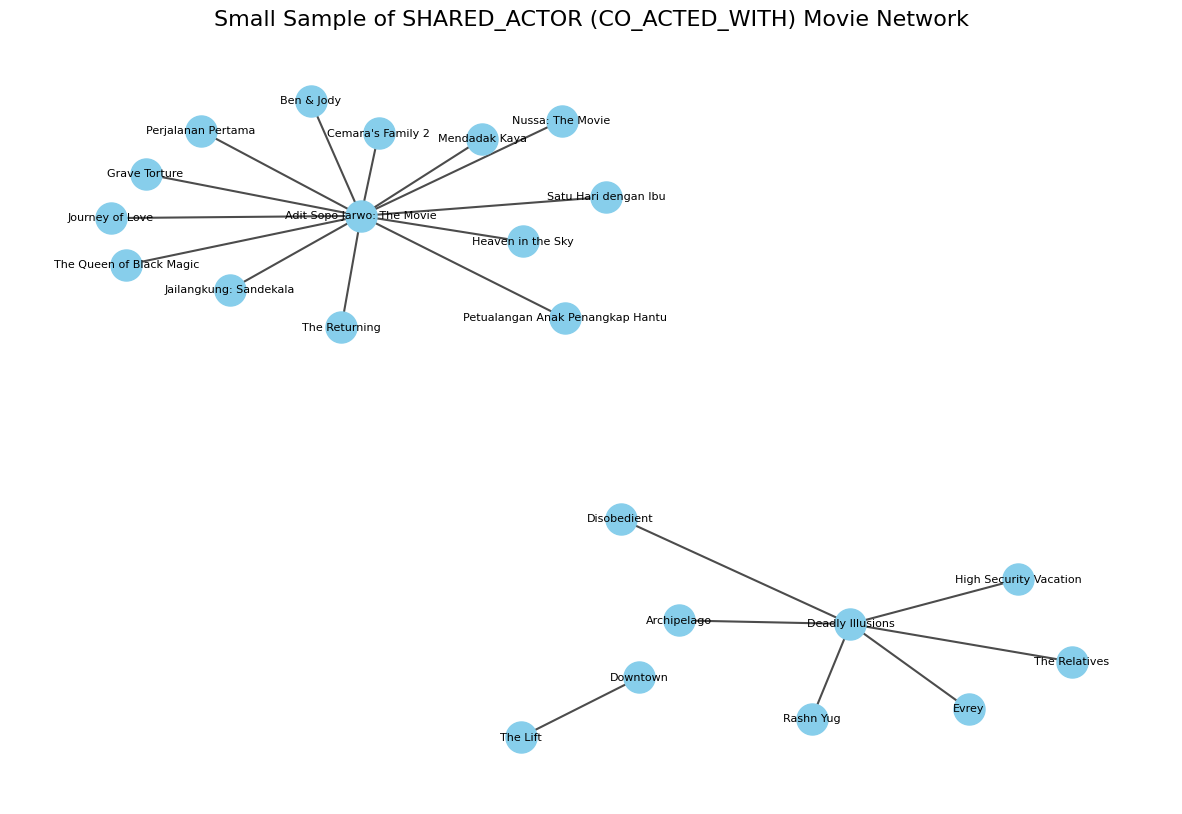

In [12]:
# Build NetworkX Graph
G = nx.Graph()

# Add edges
for idx, row in df.iterrows():
    G.add_node(row['source'], title=row['source_title'])
    G.add_node(row['target'], title=row['target_title'])
    G.add_edge(row['source'], row['target'])

# Step 4: Visualize the Graph
plt.figure(figsize=(15, 10))

# Layout for better separation
pos = nx.spring_layout(G, k=0.5)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)

# Draw labels
labels = {node: data['title'] for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Small Sample of SHARED_ACTOR (CO_ACTED_WITH) Movie Network", fontsize=16)
plt.axis('off')
plt.show()

### genre similarity (related to)

we will shared_genres and genre_count when creating similarity graph

Run it in neo4j browser to create genreCount

CALL apoc.periodic.iterate(
  
  "
  MATCH (m:Movie)
  RETURN m, count { (m)-[:IN_GENRE]->() } AS genreCount
  ",
  "
  SET m.genreCount = genreCount
  ",
  {
    batchSize: 1000,
    parallel: false
  }

)

YIELD batches, total
RETURN batches, total;


In [3]:
# Fetch all movie-genre mappings
query = """
MATCH (m:Movie)-[:IN_GENRE]->(g:Genre)
RETURN id(m) AS movie_id, id(g) AS genre_id
"""
df = graph.run(query).to_data_frame()

In [4]:
df.head()

,movie_id,genre_id
0,77,144158
1,88,144158
2,121,144158
3,128,144158
4,205,144158


In [ ]:
CALL gds.graph.project(
  'moviesGenresGraph',
  ['Movie', 'Genre'],
  {
    IN_GENRE: {
      type: 'IN_GENRE',
      orientation: 'UNDIRECTED'
    }
  }
)
YIELD graphName, nodeCount, relationshipCount;

In [ ]:
CALL gds.nodeSimilarity.stream('moviesGenresGraph', {
  nodeLabels: ['Movie'],
  relationshipTypes: ['IN_GENRE'],
  similarityCutoff: 0.0,          // allow even low similarities
  topK: 5                         // only keep top 5 similar
})
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).title AS Movie1,
       gds.util.asNode(node2).title AS Movie2,
       similarity
ORDER BY similarity DESC
LIMIT 100;


In [ ]:
CALL gds.nodeSimilarity.write('moviesGenresGraph', {
  nodeLabels: ['Movie'],
  relationshipTypes: ['IN_GENRE'],
  similarityCutoff: 0.0,
  topK: 5,
  writeRelationshipType: 'RELATED_TO',
  writeProperty: 'score'
})
YIELD nodesCompared, relationshipsWritten, similarityDistribution;


### construct similarity graph (SIMILAR_TO calculated using release year, is adult, runtime minutes and regions)

In [3]:
query = """
MATCH (m:Movie)
WHERE m.regions IS NOT NULL 
  AND m.runtimeMinutes IS NOT NULL 
  AND m.year IS NOT NULL 
  AND m.isAdult IS NOT NULL
RETURN m.id AS movie_id, 
       m.regions AS regions, 
       m.runtimeMinutes AS runtimeMinutes, 
       m.isAdult AS isAdult, 
       m.year AS releaseYear
"""

df = graph.run(query).to_data_frame()

In [4]:
df['movie_id'] = df['movie_id'].astype(str)
df['regions'] = df['regions'].apply(lambda x: x if isinstance(x, list) else [])

In [5]:
df.head()

,movie_id,regions,runtimeMinutes,isAdult,releaseYear
0,tt13465152,"[AE, CA, IN]",\N,0,2022
1,tt13465228,"[DE, FR, ID]",82,0,2021
2,tt13465592,"[DE, ES, FR, GB, JP, MX, RU, US, XWW]",108,0,2020
3,tt13465976,"[CA, ES, PL, UA, XWW]",85,0,2020
4,tt13466038,"[GB, PL, US, XWW]",85,0,2020


In [6]:
# Create feature vectors
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
import numpy as np

# Encode regions
mlb = MultiLabelBinarizer()
region_encoded = mlb.fit_transform(df['regions'])
region_df = pd.DataFrame(region_encoded, index=df['movie_id'], columns=mlb.classes_)

In [7]:
# Replace IMDb-style missing string values '\N' with NaN
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')
df['releaseYear'] = pd.to_numeric(df['releaseYear'], errors='coerce')

# Drop rows with missing numeric values
df = df.dropna(subset=['runtimeMinutes', 'releaseYear'])

In [8]:
# Normalize numerical features
scaler = MinMaxScaler()
df[['runtimeMinutes', 'releaseYear']] = scaler.fit_transform(df[['runtimeMinutes', 'releaseYear']])

In [9]:
# Final feature matrix
feature_matrix = np.hstack([
    region_df.loc[df['movie_id']].values,
    df[['runtimeMinutes', 'isAdult', 'releaseYear']].values
]).astype('float32')

movie_ids = df['movie_id'].values

In [14]:
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = torch.tensor(feature_matrix, device=device)
X = torch.nn.functional.normalize(X, p=2, dim=1)

top_k = 5
batch_size = 1000  # can increase depending on available VRAM

edges = []

for start in tqdm(range(0, X.shape[0], batch_size)):
    end = min(start + batch_size, X.shape[0])
    batch = X[start:end]  # shape: (batch_size, dim)

    # cosine similarity between batch and all
    sim = torch.matmul(batch, X.T)  # shape: (batch_size, total_movies)

    # mask self-similarity (if batch includes diagonal entries)
    for i in range(batch.shape[0]):
        sim[i, start + i] = -1  # prevent matching to self

    # get top-k
    topk_sim, topk_indices = torch.topk(sim, top_k, dim=1)

    for i in range(batch.shape[0]):
        src_id = movie_ids[start + i]
        for j in range(top_k):
            tgt_id = movie_ids[topk_indices[i][j].item()]
            score = float(topk_sim[i][j].item())
            edges.append((src_id, tgt_id, score))

# Back to DataFrame
similarity_df = pd.DataFrame(edges, columns=['source', 'target', 'similarity'])

100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [02:37<00:00,  1.58it/s]


In [17]:
similarity_df.to_csv("year_region_isAdult_similarity.csv", index=False)

In [18]:
def write_similarity_to_neo4j(df, chunk_size=5000):
    for start in tqdm(range(0, len(df), chunk_size)):
        chunk = df.iloc[start:start+chunk_size]
        rows = chunk.to_dict('records')
        graph.run("""
        UNWIND $rows AS row
        MATCH (m1:Movie {id: row.source})
        MATCH (m2:Movie {id: row.target})
        MERGE (m1)-[r:SIMILAR_TO]->(m2)
        SET r.score = row.similarity
        """, parameters={"rows": rows})

In [19]:
write_similarity_to_neo4j(similarity_df)

100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:49<00:00,  5.01it/s]


visualize small part of graph

In [26]:
query = """
MATCH (m1:Movie)-[r:SIMILAR_TO]->(m2:Movie)
RETURN m1.id AS source, m1.title AS source_title,
       m2.id AS target, m2.title AS target_title,
       r.score AS similarity
LIMIT 50
"""

df_sample = graph.run(query).to_data_frame()

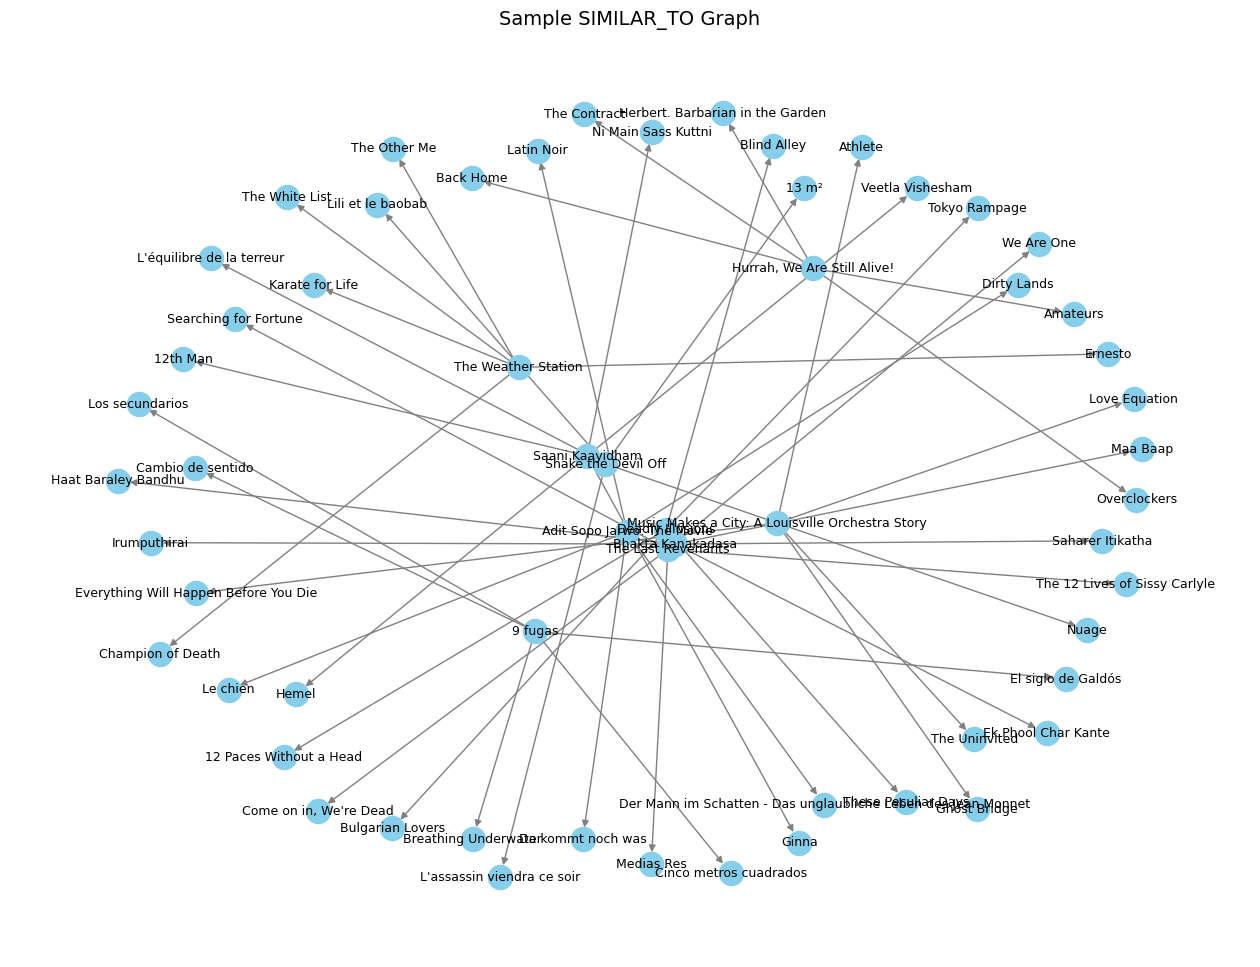

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes and edges
for _, row in df_sample.iterrows():
    G.add_node(row['source'], label=row['source_title'])
    G.add_node(row['target'], label=row['target_title'])
    G.add_edge(row['source'], row['target'], weight=row['similarity'])

# Layout
pos = nx.spring_layout(G, k=0.3)

plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
nx.draw_networkx_labels(G, pos, labels={n: G.nodes[n]['label'] for n in G.nodes}, font_size=9)
plt.title("Sample SIMILAR_TO Graph", fontsize=14)
plt.axis('off')
plt.show()
